# Chapter 7-9 : Turing Machines and Universal TM

In [1]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [2]:
def myred(x):
    CRED = '\033[91m'
    CEND = '\033[0m'
    return CRED+x+CEND

def mygreen(x):
    CGREEN= '\033[32m'
    CEND = '\033[0m'
    return CGREEN+x+CEND


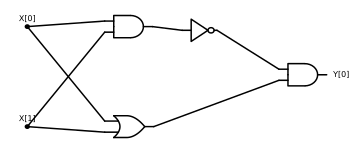

In [3]:
def XOR2(a,b):
    t  = NOT(AND(a,b))
    u =  OR(a,b)
    return AND(t,u)

def XOR(X):
    c = XOR2(X[0],X[1])
    for i in range(2,len(X)):
        c = XOR2(c,X[i])
    return c

circuit(XOR2)

In [4]:
# circuit(XOR,10)

In [5]:
#for n in range(2,10):
#    C = circuit(XOR,n)
#    C.draw()

In [37]:
import collections 
import inspect
import re

class QuitExecution(Exception):
    pass

class HaltExecution(Exception):
    pass

def extractstates(transition):
    src = inspect.getsource(transition)
    strings = re.findall( r'(?<!f)"[a-zA-Z\_0-9]*"', src, re.I | re.M)
    strings += re.findall( r"(?<!f)'[a-zA-Z\_0-9]*'", src, re.I | re.M)
    alphabet = [ "▷", "·","0", "1" ]
    states = [ "START"]
    if src.find("boilerplate(")>=0:
        bpstates = ["OUTPUT0","OUTPUT1","0ANDSTOP","1ANDSTOP"]
    else: 
        bpstates = []
    for s in strings:
        t = s[1:-1]
        if not t: continue
        if len(t)>1:
            if not t in states and not t in bpstates:
                states.append(t)
        else:
            if not t in alphabet and not t in ["L","R","H","S"]:
                alphabet.append(t)
    states += bpstates
    return alphabet, states
    
class TuringMachine:
   
    def transition_table(self):
    
        T = {}
        for i, s in enumerate(self.states):
            for a in self.alphabet:
                _s,_a,_m = self.transition(s,a)
                T[(i,a)] = (self.states.index(_s),_a,_m)
        return T
        
        
        
    def printtable(self,boiler=False):
        header = ["State", "Sym", "New State", "New Sym", "Move"]
        res = [header]
        bpstates = ["OUTPUT0","OUTPUT1","0ANDSTOP","1ANDSTOP"] if not boiler else []
        skipped = False
        for i, s in enumerate(self.states):
            if s in bpstates: 
                skipped = True
                continue
            for a in self.alphabet:
                s_, a_, m_ = self.transition(s,a)
                res.append([f"{i} ({s})", a, s_, a_, m_ ])
        if skipped: res.append(["_boilerplate_","...","...","...","..."])
        display(mdtable(res))
        
    def _repr_pretty_(self, p, cycle):
        if cycle: return "cycle"
        self.printtable()
        return None

    def __init__(self, transition):
        self.tape =  collections.defaultdict(lambda :"·")
        self.tape[0] = "▷"
        self.alphabet = [ "▷", "·","0", "1" ]
        self.transition = transition
        self.head = 0
        self.alphabet , self.states = extractstates(transition)
        self.state = "START"
        self.MAXSTEPS = 60
        self.lenstate = max([len(s) for s in self.states])
        self.history = []
        
    def input(self, x):
        self.tape = [ "▷" ] + [str(a) for a in x ] + [ "·" ]
        self.state = "START"
        self.head = 0 
    
    def printstate(self):
        tape_ = [self.tape[i] if i != self.head else myred(self.tape[i]) for i in range(len(self.tape))]
        print(self.state.ljust(self.lenstate) + " "+ "".join(tape_))
        return None
    
    
    def next(self):
        self.history.append((self.state, self.head, list(self.tape)))
        self.state,self.tape[self.head],move = self.transition(self.state, self.tape[self.head])
        if not self.state in self.states:
            self.states.append(self.state)
        if move=="L":
            self.head = max(0, self.head-1)
        if move =="R":
            self.head += 1
            if self.head == len(self.tape):
                self.tape.append("·")
        if move =="H":
            raise HaltExecution("Halted")
    
    def prev(self):
        if not self.history:
            raise Exception("Can't go back - history is empty")
        self.state,self.head, self.tape = self.history.pop()
        
    def run(self,iterate = False, maxsteps = 0):
        if iterate:
            print("q(uit), n(ext),p(rev),c(lear),r(un),s(kip) XX")
        if not maxsteps:
            maxsteps = self.MAXSTEPS
        t = 0
        noprinting = 0
        quit_cmd = False
        try:
            while True:
                if noprinting>0:
                    noprinting -= 1
                else:
                    self.printstate()
                if iterate and noprinting<=0:
                    cmd = input("")
                    #CURSOR_UP_ONE = '\x1b[1A'
                    #ERASE_LINE = '\x1b[2K'
                    #print(CURSOR_UP_ONE + ERASE_LINE + CURSOR_UP_ONE)
                    
                    c = cmd[0] if cmd else "n"
                    if c=="c":
                        clear_output()
                    elif c=="r":
                        iterate = False
                    elif c=="s":
                        _,num = cmd.split(' ')
                        print("...")
                        noprinting = int(num)
                    elif c=="p":
                        self.prev()
                        t -= 1
                        continue
                    elif c=="q":
                        raise QuitExecution("User quit")
                self.next()
                if t >= maxsteps:
                    raise Exception("Too many steps")
                t += 1
               
        except HaltExecution as e:
            msg = str(e)
            self.printstate()
            y = ""
            i = 1
            while self.tape[i] != "·":
                y += self.tape[i]
                i += 1
            return y
        except  QuitExecution as e:
            print(str(e))
            

            

__Q:__ Write Turing machine that computes $XOR:\{0,1\}^n \rightarrow \{0,1\}$

In [38]:
def xortm(state,sym):
    move = "R"
    if state=="START":
        state = "EVEN"
    elif state in ["EVEN","ODD"]:
        if sym== "·":
            state = "OUTPUT1" if state=="ODD" else "OUTPUT0"
            move  = "L"
        elif sym=="1":
            state = "EVEN" if state=="ODD" else "ODD"
    else:
        state,sym,move = boilerplate(state,sym)
    return state,sym,move

In [39]:
def boilerplate(state,sym):
    move = "H"
    if state in ["OUTPUT1","OUTPUT0"]:
        if sym != "▷":
            move = "L"
            sym= "·"
        else:
            move = "R"
            state = state[-1]+"ANDSTOP"
    elif state[1:] =="ANDSTOP":
        move = "H"
        sym = state[0]
    return state,sym,move


In [40]:
MXOR = TuringMachine(xortm)
MXOR.printtable(False)

<B>State        </B> | <B>Sym          </B> | <B>New State    </B> | <B>New Sym      </B> | <B>Move         </B>
--------------|--------------|--------------|--------------|--------------
0 (START)     | ▷             | EVEN          | ▷             | R            
0 (START)     | ·             | EVEN          | ·             | R            
0 (START)     | 0             | EVEN          | 0             | R            
0 (START)     | 1             | EVEN          | 1             | R            
1 (EVEN)      | ▷             | EVEN          | ▷             | R            
1 (EVEN)      | ·             | OUTPUT0       | ·             | L            
1 (EVEN)      | 0             | EVEN          | 0             | R            
1 (EVEN)      | 1             | ODD           | 1             | R            
2 (ODD)       | ▷             | ODD           | ▷             | R            
2 (ODD)       | ·             | OUTPUT1       | ·             | L            
2 (ODD)       | 0             | ODD           | 0             | R            
2 (ODD)       | 1             | EVEN          | 1             | R            
_boilerplate_ | ...           | ...           | ...           | ...          


In [41]:
MXOR.input("1011")
MXOR.printstate()

START    ▷1011·


In [42]:
MXOR.run()

START    ▷1011·
EVEN     ▷1011·
ODD      ▷1011·
ODD      ▷1011·
EVEN     ▷1011·
ODD      ▷1011·
OUTPUT1  ▷1011·
OUTPUT1  ▷101··
OUTPUT1  ▷10···
OUTPUT1  ▷1····
OUTPUT1  ▷·····
1ANDSTOP ▷·····
1ANDSTOP ▷1····


'1'

__Q:__ Write a TM $M$ such that for every $x\in \{0,1\}^n$, if $M$'s tape is initialized with $\triangleright x_0 x_1 \cdots x_{n-1} \cdots$ then when it halts the tape is $\triangleright PAL(x) \cdots$ where $PAL(x)=1$ iff $x_i=x_{n-i}$ for every $i\in [n]$.

In [49]:
def palindrome(state,sym):
    if sym== "▷" and state in ["START","SCANLEFT"]:
        state = "LEFTMOST"
        move = "R"
    elif state == "LEFTMOST":
        if sym == "·":
            state, move = "OUTPUT1","S"
        else:
            state = "LOOK0_SAW0" if sym=="0" else "LOOK1_SAW1"
            sym,move  = "·","R"
    elif state in [ "LOOK0_SAW0", "LOOK0_SAW1", "LOOK1_SAW0", "LOOK1_SAW1" ]:
        if sym == "▷":
            move = "H"
        elif sym == "·":
            state = "OUTPUT0" if state[4] != state[9] else "ERASE"
            move  = "L"
        else:
            state, move = state[:-1]+sym, "R"
    elif state == "ERASE":
        if sym == "·":
            state,move = "LEFTMOST","R"
        else:
            state,sym,move = "SCANLEFT", "·", "L"
    elif state == "SCANLEFT":
        if sym == "·":
            state,move = "LEFTMOST","R"
        else:
            move = "L"
    else:
        state,sym,move = boilerplate(state,sym)
    return state,sym,move

In [50]:
PalM = TuringMachine(palindrome)
PalM

<B>State         </B> | <B>Sym           </B> | <B>New State     </B> | <B>New Sym       </B> | <B>Move          </B>
---------------|---------------|---------------|---------------|---------------
0 (START)      | ▷              | LEFTMOST       | ▷              | R             
0 (START)      | ·              | START          | ·              | H             
0 (START)      | 0              | START          | 0              | H             
0 (START)      | 1              | START          | 1              | H             
1 (SCANLEFT)   | ▷              | LEFTMOST       | ▷              | R             
1 (SCANLEFT)   | ·              | LEFTMOST       | ·              | R             
1 (SCANLEFT)   | 0              | SCANLEFT       | 0              | L             
1 (SCANLEFT)   | 1              | SCANLEFT       | 1              | L             
2 (LEFTMOST)   | ▷              | LOOK1_SAW1     | ·              | R             
2 (LEFTMOST)   | ·              | OUTPUT1        | ·              | S             
2 (LEFTMOST)   | 0              | LOOK0_SAW0     | ·              | R             
2 (LEFTMOST)   | 1              | LOOK1_SAW1     | ·              | R             
3 (LOOK0_SAW0) | ▷              | LOOK0_SAW0     | ▷              | H             
3 (LOOK0_SAW0) | ·              | ERASE          | ·              | L             
3 (LOOK0_SAW0) | 0              | LOOK0_SAW0     | 0              | R             
3 (LOOK0_SAW0) | 1              | LOOK0_SAW1     | 1              | R             
4 (LOOK1_SAW1) | ▷              | LOOK1_SAW1     | ▷              | H             
4 (LOOK1_SAW1) | ·              | ERASE          | ·              | L             
4 (LOOK1_SAW1) | 0              | LOOK1_SAW0     | 0              | R             
4 (LOOK1_SAW1) | 1              | LOOK1_SAW1     | 1              | R             
5 (LOOK0_SAW1) | ▷              | LOOK0_SAW1     | ▷              | H             
5 (LOOK0_SAW1) | ·              | OUTPUT0        | ·              | L             
5 (LOOK0_SAW1) | 0              | LOOK0_SAW0     | 0              | R             
5 (LOOK0_SAW1) | 1              | LOOK0_SAW1     | 1              | R             
6 (LOOK1_SAW0) | ▷              | LOOK1_SAW0     | ▷              | H             
6 (LOOK1_SAW0) | ·              | OUTPUT0        | ·              | L             
6 (LOOK1_SAW0) | 0              | LOOK1_SAW0     | 0              | R             
6 (LOOK1_SAW0) | 1              | LOOK1_SAW1     | 1              | R             
7 (ERASE)      | ▷              | SCANLEFT       | ·              | L             
7 (ERASE)      | ·              | LEFTMOST       | ·              | R             
7 (ERASE)      | 0              | SCANLEFT       | ·              | L             
7 (ERASE)      | 1              | SCANLEFT       | ·              | L             
_boilerplate_  | ...            | ...            | ...            | ...           


In [51]:
PalM.input("11001")
PalM.printstate()

START      ▷11001·


In [52]:
PalM.run()

START      ▷11001·
LEFTMOST   ▷11001·
LOOK1_SAW1 ▷·1001·
LOOK1_SAW1 ▷·1001·
LOOK1_SAW0 ▷·1001·
LOOK1_SAW0 ▷·1001·
LOOK1_SAW1 ▷·1001·
ERASE      ▷·1001·
SCANLEFT   ▷·100··
SCANLEFT   ▷·100··
SCANLEFT   ▷·100··
SCANLEFT   ▷·100··
LEFTMOST   ▷·100··
LOOK1_SAW1 ▷··00··
LOOK1_SAW0 ▷··00··
LOOK1_SAW0 ▷··00··
OUTPUT0    ▷··00··
OUTPUT0    ▷··0···
OUTPUT0    ▷······
OUTPUT0    ▷······
OUTPUT0    ▷······
0ANDSTOP   ▷······
0ANDSTOP   ▷0·····


'0'

In [53]:
PalM.transition_table()

{(0, '▷'): (2, '▷', 'R'),
 (0, '·'): (0, '·', 'H'),
 (0, '0'): (0, '0', 'H'),
 (0, '1'): (0, '1', 'H'),
 (1, '▷'): (2, '▷', 'R'),
 (1, '·'): (2, '·', 'R'),
 (1, '0'): (1, '0', 'L'),
 (1, '1'): (1, '1', 'L'),
 (2, '▷'): (4, '·', 'R'),
 (2, '·'): (9, '·', 'S'),
 (2, '0'): (3, '·', 'R'),
 (2, '1'): (4, '·', 'R'),
 (3, '▷'): (3, '▷', 'H'),
 (3, '·'): (7, '·', 'L'),
 (3, '0'): (3, '0', 'R'),
 (3, '1'): (5, '1', 'R'),
 (4, '▷'): (4, '▷', 'H'),
 (4, '·'): (7, '·', 'L'),
 (4, '0'): (6, '0', 'R'),
 (4, '1'): (4, '1', 'R'),
 (5, '▷'): (5, '▷', 'H'),
 (5, '·'): (8, '·', 'L'),
 (5, '0'): (3, '0', 'R'),
 (5, '1'): (5, '1', 'R'),
 (6, '▷'): (6, '▷', 'H'),
 (6, '·'): (8, '·', 'L'),
 (6, '0'): (6, '0', 'R'),
 (6, '1'): (4, '1', 'R'),
 (7, '▷'): (1, '·', 'L'),
 (7, '·'): (2, '·', 'R'),
 (7, '0'): (1, '·', 'L'),
 (7, '1'): (1, '·', 'L'),
 (8, '▷'): (10, '▷', 'R'),
 (8, '·'): (8, '·', 'L'),
 (8, '0'): (8, '·', 'L'),
 (8, '1'): (8, '·', 'L'),
 (9, '▷'): (11, '▷', 'R'),
 (9, '·'): (9, '·', 'L'),
 (9, '0'):

## Evaluating TMs

In [ ]:
# Use 

In [61]:
def EVAL(δ,x):
    Tape = ["▷"] + [a for a in x]
    i = 0; s = 0 
    while True:
        s, Tape[i], d = δ[(s,Tape[i])] 
        if d == "H": break
        if d == "L": i = max(i-1,0)
        if d == "R": i += 1
        if i>= len(Tape): Tape.append('Φ')
    return Tape[1]

In [ ]:
def EVAL(δ,x): 
    '''Evaluate TM given by transition table δ 
    on input x'''
    Tape = ["▷"] + [a for a in x]
    i = 0; s = 0 # i = head pos, s = state
    while True:
        s, Tape[i], d = δ[(s,Tape[i])] 
        if d == "H": break
        if d == "L": i = max(i-1,0)
        if d == "R": i += 1
        if i>= len(Tape): Tape.append('Φ')
            
    j = 1; Y = [] # produce output
    while Tape[j] != 'Φ': 
        Y.append(Tape[j])
        j += 1
    return Y

In [60]:
EVAL(PalM.transition_table(),"11011")

'1'

## NAND-TM

In [ ]:
import time

def extractvars(src):
    varnames = re.findall( r'(?<!f)[a-zA-Z\_0-9]+', src, re.I | re.M)
    arrays = ["X","X_nonblank","Y","Y_nonblank"]
    scalars = []
    for t in varnames:
        if t in ['i','0','1'] or t=='NAND': continue
        if t[0].isupper():
            if not t in arrays: arrays.append(t)
        else:
            if not t in scalars: scalars.append(t)
    return scalars, arrays
    
class NANDTM:
   
        
    def _repr_pretty_(self, p, cycle):
        if cycle: return "cycle"
        print (self.source)
        
    def __init__(self, source):
        self.source = [l for l in source.split('\n') if l]
        self.scalars , self.arrays  =  extractvars(source)
        self.vals = collections.defaultdict(int)
        self.i = 0
        self.pc = 0
        self.maxlen = 1
        self.namelen = max([len(a) for a in self.scalars]+[len(a) for a in self.arrays])
        self.MAXSTEPS = 50
        self.modified = ()
        
    def getval(self,varname, i = 0):
        return self.vals[(varname,i)]
        
    def setval(self,varname,i,val):
        self.vals[(varname,i)] = val
        
    
    def input(self, x):
        for i,a in enumerate(x):
            self.setval("X",i,int(a))
            self.setval("X_nonblank",i,1)
        self.pc = 0
        self.i = 0
        self.maxlen = len(x)
    
    def modifiedvar(self):
        line = self.source[self.pc]
        if line[:9] == "MODANDJMP": return ("_",0)
        foo, op, bar, blah = parseline(line)
        if foo[-1]==']':
            j = foo.find("[")
            name_ = foo[:j]
            i_    = self.i if foo[j+1]=='i' else int(foo[j+1:-1])
        else:
            name_ = foo
            i_ = 0
        return name_,i_
    
    def printstate(self):
        res = ""
        def arrvals(name):
            def v(name,i):
                name_,i_ = self.modifiedvar()
                a = str(self.getval(name,i))
                if (name_,i_)==(name,i):
                    return mygreen(a)
                if self.i == i:
                    return myred(a)
                return a
            return "".join([v(name,i) for i in range(self.maxlen) ])
        name_,i_ = self.modifiedvar()
        
        for a in self.arrays:
            b = mygreen(a.ljust(self.namelen)) if a==name_ else a.ljust(self.namelen)
            res += b + ": "+ arrvals(a)+"\n"
        for a in self.scalars:
            b = mygreen(a.ljust(self.namelen)) if a==name_ else a.ljust(self.namelen)
            res += b + ": "+ str(self.getval(a))+"\n"
        res += "\n"
        for p,l in enumerate(self.source):
            if p == self.pc:
                l = myred(l)
            res += l+"\n"
        print(res)
    
    
    def next(self,printstate = False):
        def pname(foo):
            if foo[-1]==']':
                j = foo.find("[")
                name = foo[:j]
                i    = self.i if foo[j+1]=='i' else int(foo[j+1:-1])
            else:
                name = foo
                i = 0
            return name,i
        
        line = self.source[self.pc]
        if line[:9] == "MODANDJMP":
            j = line.find("(")
            k = line.find(",")
            l = line.find(")")
            a = self.getval(*pname(line[j+1:k].strip()))
            b = self.getval(*pname(line[k+1:l].strip()))
            if printstate:
                clear_output()
                self.printstate()
            if not a and not b: raise HaltExecution("halted")
            if b:
                if a: self.i += 1
                else: self.i = max(0,self.i-1)
            self.pc = 0
            self.maxlen = max(self.maxlen, self.i+1)
            return
        foo, op, bar, blah = parseline(line)
        a = self.getval(*pname(bar))
        b = self.getval(*pname(blah))
        self.setval(*pname(foo),1-a*b)
        self.pc = self.pc + 1 
        if printstate:
            clear_output()
            self.printstate()
    
    def run(self,iterate = False, maxsteps = 0):
        if iterate:
            print("q(uit), n(ext),p(rev),c(lear),r(un),s(kip) XX")
        if not maxsteps:
            maxsteps = self.MAXSTEPS
        t = 0
        noprinting = 0
        quit_cmd = False
        try:
            while True:
                if noprinting>0:
                    noprinting -= 1
                else:
                    clear_output()
                    self.printstate()
                if iterate and noprinting<=0:
                    cmd = input("")
                    #CURSOR_UP_ONE = '\x1b[1A'
                    #ERASE_LINE = '\x1b[2K'
                    #print(CURSOR_UP_ONE + ERASE_LINE + CURSOR_UP_ONE)
                    
                    c = cmd[0] if cmd else "n"
                    if c=="c":
                        clear_output()
                    elif c=="r":
                        iterate = False
                    elif c=="s":
                        _,num = cmd.split(' ')
                        print("...")
                        noprinting = int(num)
                    elif c=="p":
                        self.prev()
                        t -= 1
                        continue
                    elif c=="q":
                        raise QuitExecution("User quit")
                self.next()
                if t >= maxsteps:
                    raise Exception("Too many steps")
                t += 1
               
        except HaltExecution as e:
            msg = str(e)
            clear_output()
            self.printstate()
            y = ""
            i = 0
            while self.getval("Y_nonblank",i) :
                y += str(self.getval("Y",i))
                i += 1
            return y
        except  QuitExecution as e:
            print(str(e))
            

            

In [87]:
source = r'''temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])'''

xorprog = NANDTM(source)
xorprog.input("111")

In [88]:
xorprog.printstate()

X         : 111
X_nonblank: 111
Y         : 000
Y_nonblank: 000
MODANDJMP : 000
temp_0    : 0
temp_2    : 0
temp_3    : 0
temp_4    : 0

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])



In [89]:
xorprog.input("1011")
xorprog.printstate()

X         : 1011
X_nonblank: 1111
Y         : 0000
Y_nonblank: 0000
MODANDJMP : 0000
temp_0    : 0
temp_2    : 0
temp_3    : 0
temp_4    : 0

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])



In [90]:
xorprog.run(False)

X         : 10110
X_nonblank: 11110
Y         : 10000
Y_nonblank: 10000
MODANDJMP : 00000
temp_0    : 0
temp_2    : 1
temp_3    : 1
temp_4    : 0

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])



'1'

In [163]:
xorprog.input("111")
xorprog.run(False)

X         : 11110
X_nonblank: 11110
Y         : 00000
Y_nonblank: 10000
MODANDJMP : 00000
temp_0    : 0
temp_2    : 1
temp_3    : 1
temp_4    : 1

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])



'0'

In [162]:
xorprog.next(True)

X         : 11110
X_nonblank: 11110
Y         : 00000
Y_nonblank: 10000
MODANDJMP : 00000
temp_0    : 0
temp_2    : 1
temp_3    : 1
temp_4    : 1

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJMP(X_nonblank[i],X_nonblank[i])



HaltExecution: halted